In [1]:
import numpy as np
from scipy.linalg import svd

In [2]:
class SingularValueRegressor:
    """
    : A regression object that uses the SVD to fit and predict
    : Init: specify rank r
    : .fit: solve the SVD of X and precompute beta
    : .predict: Return y hat for X_test
    """
    
    def __init__(self,r):
        """
        : Store the rank
        """
        self.r = r
        
        
    def fit(self, X, y):
        """
        : Computes and stores the SVD (use scipy.linalg.svd)
        : Computes beta for rank r singular value regression
        """
        u,d,vh = svd(X,full_matrices = False)
        
        v = np.transpose (vh)
        ut = np.transpose(u)
        
        
        d_1 = d ** (-1)
        d_1[self.r:] = 0
        d_1_m = np.diag(d_1)
        
        self.beta = v @ d_1_m @ ut @ y
        y_hat = u @ ut @ y
        
        return self.beta, y_hat
        
    def predict(self, X_test):
        """
        : Outputs the predicted y given the predictors X_test
        """
        self.X_test=X_test
        
        predicted_y = self.X_test @ self.beta
        
        return predicted_y
    
    
    def change_rank(self,r):
        """
        : Assumes that the SVD has been computed and uses it to change the rank; after
        : running the new regressor object should be as if we fit with the new rank r
        """
        self.r = r
        
        return self.predict(self.X_test)

In [3]:
def gen_LR_data(r = 10, p = 20, n = 100):
    """
    : generate data from an approx low rank regression model
    """
    alpha = np.random.chisquare(1,size = (p,r)) #X coefficients
    Z = np.random.normal(size=(n,r)) #X covariates
    beta = np.random.normal(size = r) #reg covs
    mu = Z @ beta #hidden mean
    Xmean = Z @ alpha.T #random transformation of Z
    X = Xmean + np.random.normal(0,.5,size=(n,p)) #add noise - not exactly low rank
    X_test = Xmean + np.random.normal(0,.5,size=(n,p))
    y = mu + np.random.normal(0,1,size=(n))
    y_test = mu + np.random.normal(0,1,size=(n))
    return (X,y,X_test,y_test)

In [4]:
x,y,x_test,y_test = gen_LR_data()
x_test = x_test-x_test.mean(0) #center x test
x = x - x.mean(0) #center x

In [5]:
def sse (r):
    svr = SingularValueRegressor(r)
    svr.fit(x,y)
    svr.predict(x_test)
    y_hat = svr.change_rank(r)
    sse = (np.sum((y_hat - y_test)**2))
    return sse

In [6]:
see_all = [sse(i) for i in range(1,30)]

In [7]:
import matplotlib.pyplot as plt


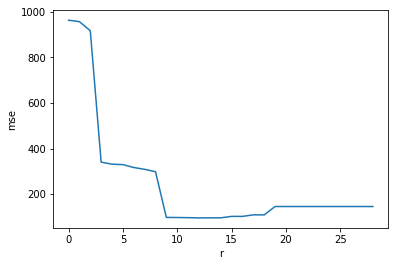

In [8]:
plt.plot(see_all)
plt.ylabel('mse')
plt.xlabel('r')
plt.show()

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model, neighbors
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.style.use('ggplot')

# dataset path
data_dir = "."

In [11]:
data_mat = pd.read_csv('hw1_data.csv')
data_mat.head()

,Y,X1,X2,X3,X4,X5,X6,X7
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


In [12]:
#checking null value in matrix
data_mat.isnull().sum()

Y     0
X1    0
X2    0
X3    6
X4    0
X5    0
X6    0
X7    0
dtype: int64

In [13]:
data_mat.mean(0)[3], data_mat.median(0)[3]

(104.46938775510205, 93.5)

by checking if there is any nan in the matrix, we can tell only x3 has 6 null values. One solution is to replace all null value with the median of x3, since simply deleting them might lose some information. Thus we check the median and mean of x3. From above, we can tell that the mean and median are close to each other, thus we conclude, we are able to replace all null value in x3 with the median of x3. 

In [14]:
data_mat['X3'] = data_mat.X3.replace(np.NaN, data_mat.median(0)[3])

In [15]:
data_mat.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
dtype: int64

By checking null value again, we are sure that there is no null value exists anymore in the matrix.

In [16]:
x = np.array(data_mat.iloc[:,1:])
x = scale(x)  #scale all x to same scale
y = np.array(data_mat.iloc[:,0])

In [17]:
def loo_risk(X,y,regmod):
    """
    Construct the leave-one-out square error risk for a regression model
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar LOO risk
    """
    loo = LeaveOneOut()
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regmod.fit(X_train,y_train)
        y_hat = regmod.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)

def emp_risk(X,y,regmod):
    """
    Return the empirical risk for square error loss
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar empirical risk
    """
    regmod.fit(X,y)
    y_hat = regmod.predict(X)
    return np.mean((y_hat - y)**2)

## Ridge Regression

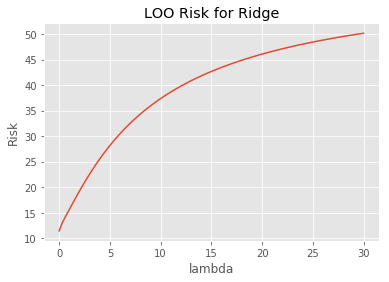

In [22]:
ridge = Ridge()
alphas = np.linspace(30,0.001,100)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=True)
rcv.fit(x,y)
coefs = []
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(x), y)
    coefs.append(ridge.coef_)

plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge');
plt.show()

In [23]:
min(LOOr),min(alphas)

(11.428758995869076, 0.001)

Notice that lambda could not take value of 0, thus in order to estimate lambda = 0, we use a value that is close enough to 0, which is 0.001.The above plot shows that MSE get the smallest value when lambda is the samllest, since the function is monotonic increasing on lambda, thus when lambda = 0, MSE get the samllest value, which is a value samller than 11.4288.

## OLS

In [24]:
loo_risk(x,y,linear_model.LinearRegression(fit_intercept=True) )

11.433893575239953

## kNN

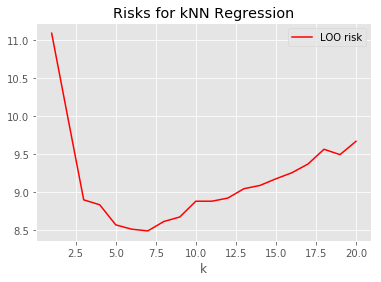

In [25]:
LOOs = []
MSEs = []
K=20#tuning k from 1 to 20
Ks = range(1,K+1)
for k in Ks:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    LOOs.append(loo_risk(x,y,knn))

plt.plot(Ks,LOOs,'r',label="LOO risk")
plt.title("Risks for kNN Regression")
plt.legend()
_ = plt.xlabel('k')

In [26]:
min((val, idx) for (idx, val) in enumerate(LOOs))

(8.488846272177211, 6)

## SVRegression

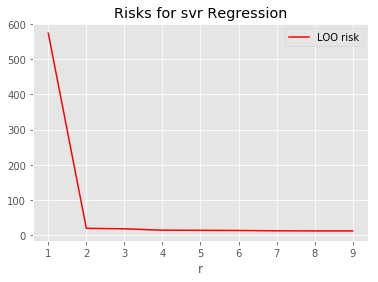

In [27]:
x_svr=np.insert(x, 0, 1, axis=1)
LOOs = []

Ks = range(1,10) #tuning k from 1 to 10
for k in Ks:
    svr = SingularValueRegressor(k)
    LOOs.append(loo_risk(x_svr,y,svr))


plt.plot(Ks,LOOs,'r',label="LOO risk")
plt.title("Risks for svr Regression")
plt.legend()
_ = plt.xlabel('r')

In [28]:
min((val, idx) for (idx, val) in enumerate(LOOs))

(11.433893575239953, 7)

Based on above, kNN has the samllest MSE value, 11.433893575239953, when r = 8( 7 is the index, thus 7 is the real value), which is the same as OLS method.

### Conclusion:
Based on comparing above four method usding LOO method for cross validation, kNN has the samllest MSE, and thus, it's the best method to fit this model. 